# CUSTOM CNN

## Setup

In [1]:
import os
import sys
import numpy as np
from pathlib import Path

In [2]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: Using Google CoLab")
except:
    print("Note: Not using Google CoLab")
    COLAB = False

if COLAB:
    if not os.path.ismount("/content/drive"):
        print("Note: Mounting drive")
        drive.mount('/content/drive')
    else:
        print("Note: Drive already mounted")

    os.system("pip install pycm")
    print("Note: pycm installed")
    os.system("pip install keras-sequential-ascii")
    print("Note: keras-sequential-ascii installed")
    os.system("pip install ann_visualizer")
    print("Note: ann_visualizer installed")

    sys.path.append("/content/drive/MyDrive/tumorclass.info")
    sys.path.append("/content/drive/MyDrive/tumorclass.info/notebooks")

    PROJECT_PATH = "/content/drive/MyDrive/tumorclass.info"

else:
    PROJECT_PATH = str(Path.cwd().parent)

DATA_PATH = os.path.join(PROJECT_PATH, "data/")
MODELS_PATH = os.path.join(PROJECT_PATH, "models/")
DATASET_PATH = os.path.join(PROJECT_PATH, "data/dataset/")
SRC_0_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_0/")
SRC_1_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_1/")
SRC_2_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_2/")
TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/")
TRAIN_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/normal/")
TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/lgg/")
TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/hgg/")
TEST_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/")
TEST_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/normal/")
TEST_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/lgg/")
TEST_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/hgg/")
VALID_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/")
VALID_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/normal/")
VALID_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/lgg/")
VALID_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/hgg/")
AUG_TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/")
AUG_TRAIN_NORMAL_PATH = os.path.join(
    PROJECT_PATH, "data/dataset/aug_train/normal/"
)
AUG_TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/lgg/")
AUG_TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/hgg/")

try:
    TEST_NORMAL_FILES = np.array(sorted(os.listdir(TEST_NORMAL_PATH)))
    TEST_LGG_FILES = np.array(sorted(os.listdir(TEST_LGG_PATH)))
    TEST_HGG_FILES = np.array(sorted(os.listdir(TEST_HGG_PATH)))
except FileNotFoundError:
    print("Note: No test data found! Run preprocessing.ipynb first.")

Note: Not using Google CoLab


In [3]:
import matplotlib.pyplot as plt
from ann_visualizer.visualize import ann_viz
from keras_sequential_ascii import keras2ascii
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tools.data import (
    compare_predictions,
    confusion_matrix,
    count_params,
    enumerate_oxford,
    learning_rate_scheduler,
    p_join,
    predict_gen,
    predictor,
)
from tools.file import mkdir_if_not_exists, pickler
from tools.visualize import plot_batch, plot_epochs

In [4]:
MODEL_NAME = "cnn_custom"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_MODE = "rgb" # "grayscale"
IMAGE_CHANNELS = 3  # 1
CLASSES = ["normal", "lgg", "hgg"]
CLASS_MODE = "categorical"
SEED = 42

BATCH_SIZE = 24

## Prepare data

In [5]:
augment = True

train_gen = ImageDataGenerator(
).flow_from_directory(
    directory=(AUG_TRAIN_PATH if augment else TRAIN_PATH),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="training",
    shuffle=True,
    seed=SEED,
)

valid_gen = ImageDataGenerator(
).flow_from_directory(
    directory=VALID_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="validation",
    shuffle=True,
    seed=SEED,
)

test_gen = ImageDataGenerator(
).flow_from_directory(
    directory=TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False,
    seed=SEED,
)

Found 1045 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [6]:
assert train_gen.n == 1045 if augment else train_gen.n == 471
assert valid_gen.n == 204
assert test_gen.n == 60
assert (
    train_gen.num_classes
    == test_gen.num_classes
    == valid_gen.num_classes
    == 3
)

In [7]:
images, labels = next(train_gen)

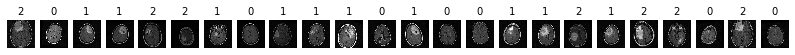

In [8]:
plot_batch(images, labels, argmax=True)

## Build Fine-tuned CUSTOM model

In [9]:
model = Sequential()

# the 2 first values in in input shape is the width and height of the image, the last is the color channel.
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)  # X_train.shape[1:]  # <-- Not hidden, not counted

# ### Conv2D ###
# filters is the number of filters that is learning.
# The kernel_size is the filter/matrix size
# The stride is the actual convolving.
# padding = "same" keeps the origional dimensionality

model.add(
    Conv2D(
        32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        input_shape=input_shape,
    )
)
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

# First dense layer in model has to have a flatten
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# Dropout should not be added to last hidden layer
model.add(Dense(256, activation="relu"))

### Will give same result ###
## Binary only
# When using loss="binary_crossentropy"
# model.add(Dense(1, activation="sigmoid"))

## Can also be used when more than two classes
# When using loss="categorical_crossentropy"
model.add(Dense(3, activation="softmax"))


2022-01-07 20:38:40.684234: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
mkdir_if_not_exists(MODELS_PATH)
with open(f"{MODELS_PATH}{MODEL_NAME}_model_summary.txt", "w") as writer:
    model.summary(print_fn=lambda x: writer.write(x + '\n'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 56, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0

In [11]:
# model.summary()
params = count_params(model)
print(f"Trainable params: {params['trainable_params']:,}")
print(f"Non-trainable params: {params['non_trainable_params']:,}")
assert params['trainable_params'] == 6_611_459
assert params['non_trainable_params'] == 0

Trainable params: 6,611,459
Non-trainable params: 0.0


In [12]:
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    224  224    3
              Conv2D    \|/  -------------------       896     0.0%
                relu   #####    224  224   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     56   56   32
             Dropout    | || -------------------         0     0.0%
                       #####     56   56   32
              Conv2D    \|/  -------------------     18496     0.3%
                relu   #####     56   56   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     28   28   64
             Dropout    | || -------------------         0     0.0%
                       #####     28   28   64
              Conv2D    \|/  -------------------     36928     0.6%
                relu   #####     28   28   64
        MaxPooling2D   Y max -------------------         0     0.0%
              

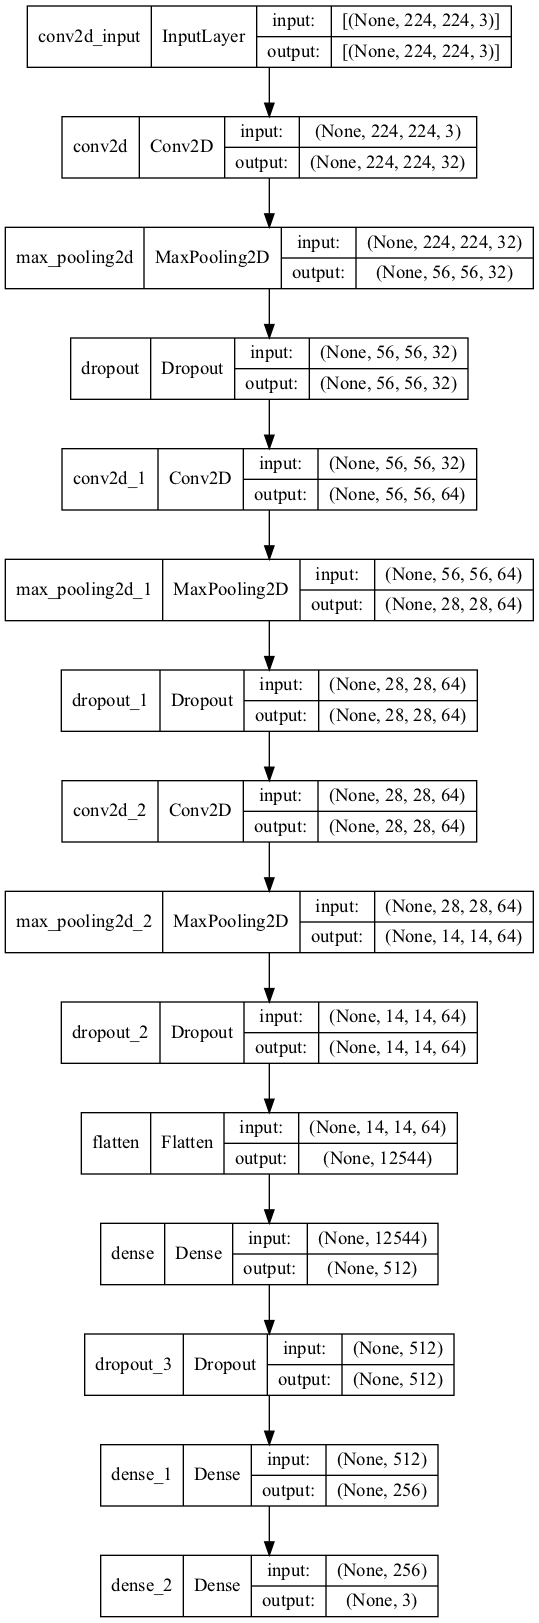

In [13]:
mkdir_if_not_exists(MODELS_PATH)
plot_model(model, show_shapes=True, to_file=f"{MODELS_PATH}{MODEL_NAME}_model_summary.png")
# Image(f"{MODEL_PATH}{MODEL_NAME}_model_summary.png")

In [14]:
mkdir_if_not_exists(MODELS_PATH)
ann_viz(model, title="CNN CUSTOM", filename=f"{MODELS_PATH}{MODEL_NAME}_model_summary.gv");

## Compile model

In [15]:
model.compile(
    optimizer=Adam(
        learning_rate=(0.001 * np.sqrt(0.1)),
        beta_1=0.9,
        beta_2=0.995,
        epsilon=1e-08,
        amsgrad=False,
        name="Adam",
    ),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Fit model

In [16]:
epochs = 50

set_callbacks = [  # None
    # "lr_schedule",
    "lr_plateau",
    "early_stopping",
    "model_checkpoint",
]

if "lr_schedule" in set_callbacks and "lr_plateau" in set_callbacks:
    set_callbacks.pop(set_callbacks.index("lr_plateau"))
    print("Note: 'LearningRateScheduler' always wins over 'ReduceLROnPlateau'\n")

callbacks = []
callback_names = []

if set_callbacks:
    if "lr_schedule" in set_callbacks:
        learning_rate_schedule = learning_rate_scheduler(
            # epoch_steps=[5, 20],  # None,
            initial_lr=round(float(model.optimizer.learning_rate.numpy()), 8),
            # lr_steps=[0.1, 0.1],  # None,
            # use_factor=True,
            verbose=1
        )
        lr_schedule = LearningRateScheduler(learning_rate_schedule)
        model.optimizer.learning_rate = learning_rate_schedule(0)
        print(
            "[LR SCHEDULE]:\n"
            f"\tEpoch_steps: {getattr(learning_rate_schedule, 'epoch_steps')}\n"
            f"\tInitial_lr: {getattr(learning_rate_schedule, 'initial_lr')}\n"
            f"\tLr_steps: {getattr(learning_rate_schedule, 'lr_steps')}\n"
            f"\tUse_factor: {getattr(learning_rate_schedule, 'use_factor')}\n"
            )
        if getattr(learning_rate_schedule, 'use_factor'):
            epcs = getattr(learning_rate_schedule, 'epoch_steps')
            curr_step = round(float(model.optimizer.learning_rate.numpy()), 8)
            print(str(f"\tEpoch 0: {curr_step:.10f}").rstrip("0"))
            for i, step in enumerate(getattr(learning_rate_schedule, 'lr_steps')):
                curr_step *= step
                print(str(f"\tEpoch {epcs[i]}: {curr_step:.10f}").rstrip("0"))
            print()

        callbacks.append(lr_schedule)
        callback_names.append("lr_schedule")

    if "lr_plateau" in set_callbacks:
        lr_plateau = ReduceLROnPlateau(
            monitor="val_loss",
            factor=np.sqrt(0.1),
            patience=2,
            verbose=1,
            mode="auto",
            # min_delta=0.01,
            cooldown=0,
            min_lr=0.5e-6,
        )
        callbacks.append(lr_plateau)
        callback_names.append("lr_plateau")

    if "early_stopping" in set_callbacks:
        early_stopping = EarlyStopping(
            monitor="val_loss",
            # min_delta=0.01,
            patience=6,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        callbacks.append(early_stopping)
        callback_names.append("early_stopping")

    if "model_checkpoint" in set_callbacks:
        model_checkpoint = ModelCheckpoint(
            filepath=p_join(MODELS_PATH, MODEL_NAME + "_" + "checkpoint.hdf5"),
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            options=None,
        )
        callbacks.append(model_checkpoint)
        callback_names.append("model_checkpoint")

print(f"Selected callbacks: {enumerate_oxford(callback_names)}")

Selected callbacks: lr_plateau, early_stopping, and model_checkpoint


In [17]:
TRAIN_STEPS_PER_EPOCH = int(train_gen.n / BATCH_SIZE)
VALID_STEPS_PER_EPOCH = int(valid_gen.n / BATCH_SIZE)
print("Train steps per epoch:", TRAIN_STEPS_PER_EPOCH)
print("Valid steps per epoch:", VALID_STEPS_PER_EPOCH)

Train steps per epoch: 43
Valid steps per epoch: 8


In [18]:
model_operation = "load"

mkdir_if_not_exists(MODELS_PATH)

clear_session()

if model_operation == "fit":
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        validation_data=valid_gen,
        validation_steps=VALID_STEPS_PER_EPOCH,
        verbose=2,
        callbacks=callbacks if len(callbacks) > 0 else None,
        # workers=2,
    )

    save_model(model, os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))

    # save model history
    pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"),
        "save",
        history,
    )

elif model_operation == "load":
    model = load_model(os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))
    history = pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"), "load"
    )

elif model_operation == "checkpoint":
    model = load_model(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_checkpoint.hdf5")
    )
    history = None

## Predict

In [19]:
predictions, y_pred, y_true, target_names = predict_gen(model=model, gen=test_gen)

3/3 [==============================] - 1s 341ms/step


In [20]:
predictions[0:5]

array([[9.9002200e-01, 9.8882411e-03, 8.9648798e-05],
       [7.4091053e-01, 2.1312995e-01, 4.5959506e-02],
       [7.5272167e-01, 2.3887306e-01, 8.4052728e-03],
       [8.7103808e-01, 1.0487391e-01, 2.4088029e-02],
       [9.4326878e-01, 3.7275344e-02, 1.9455949e-02]], dtype=float32)

In [21]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [22]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [23]:
target_names

['normal', 'lgg', 'hgg']

In [24]:
compare_predictions(y_pred, y_true, target_names)

[normal]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

[lgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

[hgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 



In [25]:
print(f"normal: {TEST_NORMAL_FILES[2]}")
print(f"lgg: {TEST_LGG_FILES[14]}")
print(f"hgg: {TEST_HGG_FILES[7]}")

normal: 11.jpg
lgg: 35.jpg
hgg: 48.jpg


In [26]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "normal", "1.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: NORMAL with 99.00% confidence.

Ratio
Normal: 99.00%
LGG: 0.99%
HGG: 0.01%


In [27]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "lgg", "35.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: LGG with 90.53% confidence.

Ratio
Normal: 4.94%
LGG: 90.53%
HGG: 4.53%


In [28]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "hgg", "48.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: HGG with 84.10% confidence.

Ratio
Normal: 0.62%
LGG: 15.28%
HGG: 84.10%


## Evaluate

In [29]:
eval_loss, eval_accuracy = model.evaluate(
    x=test_gen,
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"Evaluation loss: {eval_loss:.2f}")
print(f"Evaluation accuracy: {eval_accuracy*100:.2f}%")

3/3 [==============================] - 1s 132ms/step - loss: 0.0989 - accuracy: 1.0000
Evaluation loss: 0.10
Evaluation accuracy: 100.00%


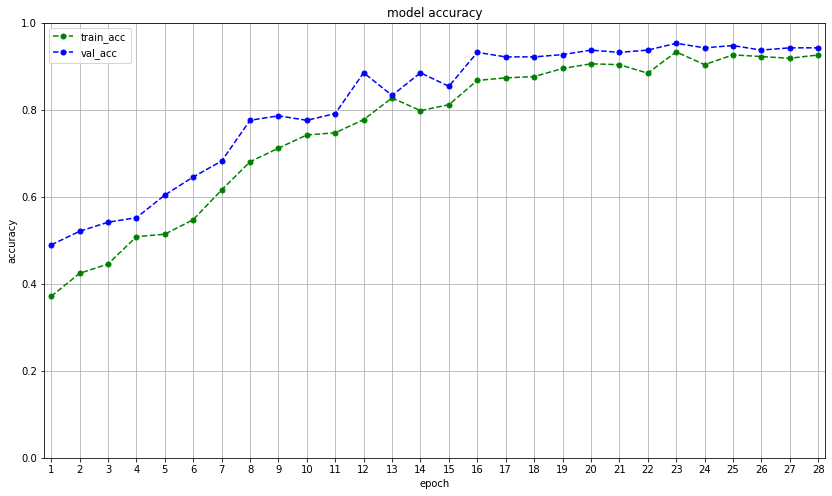

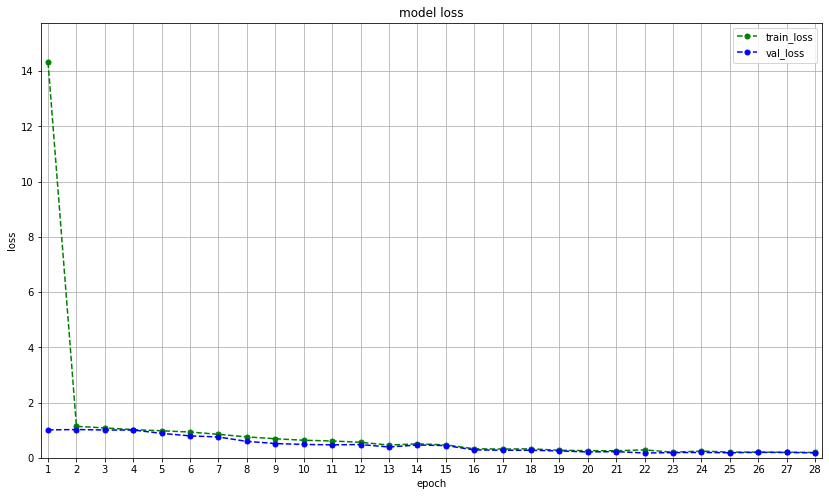

In [30]:
if history is not None:
    plot_epochs(history=history, filepath=f"{MODELS_PATH}{MODEL_NAME}")

In [31]:
cm = confusion_matrix(
    y_pred=y_pred,
    y_true=y_true,
    labels=CLASSES,
    save=True,
    path=MODELS_PATH,
    file_name=MODEL_NAME,
)

In [32]:
cm

pycm.ConfusionMatrix(classes: ['normal', 'lgg', 'hgg'])

In [33]:
cm.actual_vector

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [34]:
cm.predict_vector

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [35]:
cm.classes

['normal', 'lgg', 'hgg']

In [36]:
cm.table

{'normal': {'normal': 20, 'lgg': 0, 'hgg': 0},
 'lgg': {'normal': 0, 'lgg': 20, 'hgg': 0},
 'hgg': {'normal': 0, 'lgg': 0, 'hgg': 20}}

In [37]:
cm.normalized_table

{'normal': {'normal': 1.0, 'lgg': 0.0, 'hgg': 0.0},
 'lgg': {'normal': 0.0, 'lgg': 1.0, 'hgg': 0.0},
 'hgg': {'normal': 0.0, 'lgg': 0.0, 'hgg': 1.0}}

In [38]:
cm.matrix

{'normal': {'normal': 20, 'lgg': 0, 'hgg': 0},
 'lgg': {'normal': 0, 'lgg': 20, 'hgg': 0},
 'hgg': {'normal': 0, 'lgg': 0, 'hgg': 20}}

In [39]:
cm.normalized_matrix

{'normal': {'normal': 1.0, 'lgg': 0.0, 'hgg': 0.0},
 'lgg': {'normal': 0.0, 'lgg': 1.0, 'hgg': 0.0},
 'hgg': {'normal': 0.0, 'lgg': 0.0, 'hgg': 1.0}}

In [40]:
cm.print_matrix()

Predict      normal       lgg          hgg          
Actual
normal       20           0            0            

lgg          0            20           0            

hgg          0            0            20           




In [41]:
cm.print_normalized_matrix()

Predict      normal       lgg          hgg          
Actual
normal       1.0          0.0          0.0          

lgg          0.0          1.0          0.0          

hgg          0.0          0.0          1.0          




In [42]:
print(cm)

Predict      normal       lgg          hgg          
Actual
normal       20           0            0            

lgg          0            20           0            

hgg          0            0            20           





Overall Statistics : 

95% CI                                                            (1.0,1.0)
ACC Macro                                                         1.0
ARI                                                               1.0
AUNP                                                              1.0
AUNU                                                              1.0
Bangdiwala B                                                      1.0
Bennett S                                                         1.0
CBA                                                               1.0
CSI                                                               1.0
Chi-Squared                                                       120.0
Chi-Squared DF                             

In [43]:
cm.position()

{'normal': {'TP': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19],
  'FP': [],
  'TN': [20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59],
  'FN': []},
 'lgg': {'TP': [20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39],
  'FP': [],
  'TN': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59],
  'FN': []},
 'hgg': {'TP': [40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
  

In [44]:
cm.class_stat

{'TPR': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'TNR': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'PPV': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'NPV': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'FNR': {'normal': 0.0, 'lgg': 0.0, 'hgg': 0.0},
 'FPR': {'normal': 0.0, 'lgg': 0.0, 'hgg': 0.0},
 'FDR': {'normal': 0.0, 'lgg': 0.0, 'hgg': 0.0},
 'FOR': {'normal': 0.0, 'lgg': 0.0, 'hgg': 0.0},
 'ACC': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'F1': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'MCC': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'BM': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'MK': {'normal': 1.0, 'lgg': 1.0, 'hgg': 1.0},
 'PLR': {'normal': 'None', 'lgg': 'None', 'hgg': 'None'},
 'NLR': {'normal': 0.0, 'lgg': 0.0, 'hgg': 0.0},
 'DOR': {'normal': 'None', 'lgg': 'None', 'hgg': 'None'},
 'TP': {'normal': 20, 'lgg': 20, 'hgg': 20},
 'TN': {'normal': 40, 'lgg': 40, 'hgg': 40},
 'FP': {'normal': 0, 'lgg': 0, 'hgg': 0},
 'FN': {'normal': 0, 'lgg': 0, 'hgg': 0},
 'POP': {'normal': 60, 'lgg

In [45]:
cm.overall_stat

{'Overall ACC': 1.0,
 'Kappa': 1.0,
 'Overall RACC': 0.3333333333333333,
 'SOA1(Landis & Koch)': 'Almost Perfect',
 'SOA2(Fleiss)': 'Excellent',
 'SOA3(Altman)': 'Very Good',
 'SOA4(Cicchetti)': 'Excellent',
 'SOA5(Cramer)': 'Very Strong',
 'SOA6(Matthews)': 'Very Strong',
 'TNR Macro': 1.0,
 'TPR Macro': 1.0,
 'FPR Macro': 0.0,
 'FNR Macro': 0.0,
 'PPV Macro': 1.0,
 'ACC Macro': 1.0,
 'F1 Macro': 1.0,
 'TNR Micro': 1.0,
 'FPR Micro': 0.0,
 'TPR Micro': 1.0,
 'FNR Micro': 0.0,
 'PPV Micro': 1.0,
 'F1 Micro': 1.0,
 'Scott PI': 1.0,
 'Gwet AC1': 1.0,
 'Bennett S': 1.0,
 'Kappa Standard Error': 0.0,
 'Kappa 95% CI': (1.0, 1.0),
 'Chi-Squared': 119.99999999999999,
 'Phi-Squared': 1.9999999999999998,
 'Cramer V': 0.9999999999999999,
 'Chi-Squared DF': 4,
 '95% CI': (1.0, 1.0),
 'Standard Error': 0.0,
 'Response Entropy': 1.584962500721156,
 'Reference Entropy': 1.584962500721156,
 'Cross Entropy': 1.584962500721156,
 'Joint Entropy': 1.584962500721156,
 'Conditional Entropy': -0.0,
 'KL Div

In [46]:
cm.imbalance

False

In [47]:
cm.recommended_list

['ERR',
 'TPR Micro',
 'TPR Macro',
 'F1 Macro',
 'PPV Macro',
 'ACC',
 'Overall ACC',
 'MCC',
 'MCCI',
 'Overall MCC',
 'SOA6(Matthews)',
 'BCD',
 'Hamming Loss',
 'Zero-one Loss']

In [48]:
cm.to_array()

array([[20,  0,  0],
       [ 0, 20,  0],
       [ 0,  0, 20]])

In [49]:
cm.to_array(normalized=True)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [50]:
cm.to_array(normalized=True,one_vs_all=True, class_name="normal")

array([[1., 0.],
       [0., 1.]])

In [51]:
# print four lines. Justify text after colon
print(
    f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}\n"
    f"{cm.Overall_ACC*100:<10.2f} {cm.PPV_Macro:<10.2f}"
    f"{cm.TPR_Macro:<10.2f} {cm.F1_Macro:<10.2f}"
)

Accuracy   Precision  Recall     F1 Score  
100.00     1.00      1.00       1.00      


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

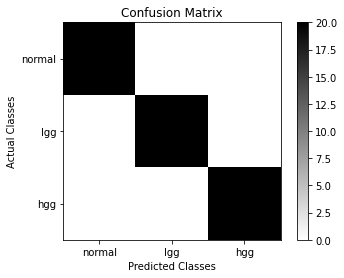

In [52]:
cm.plot()

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

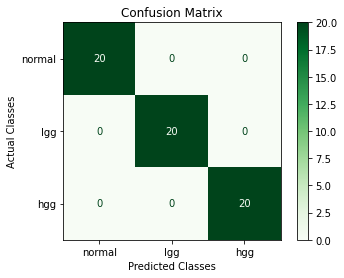

In [53]:
cm.plot(cmap=plt.cm.Greens, number_label=True)

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

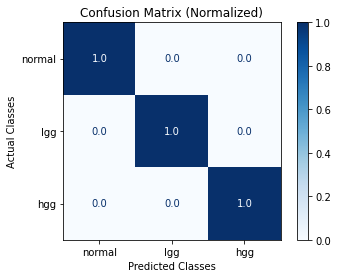

In [54]:
cm.plot(cmap=plt.cm.Blues, number_label=True, normalized=True)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

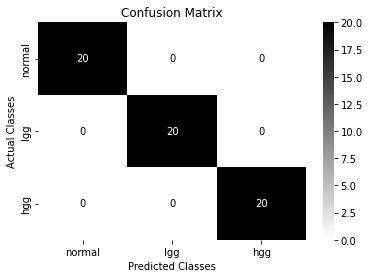

In [55]:
cm.plot(plot_lib = "seaborn", number_label=True)

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

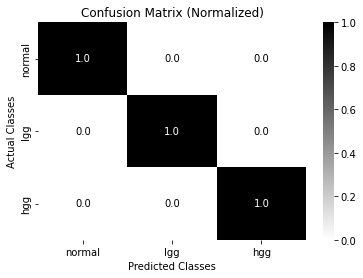

In [56]:
cm.plot(plot_lib = "seaborn", number_label=True, normalized=True)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

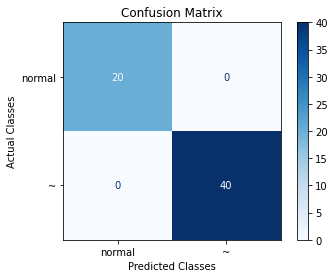

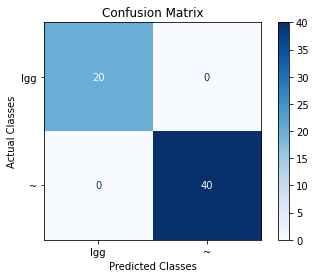

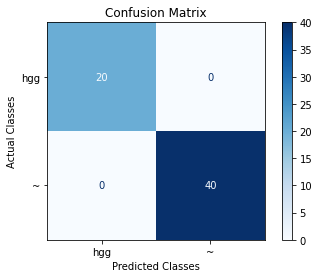

In [57]:
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="normal")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="lgg")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="hgg")

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

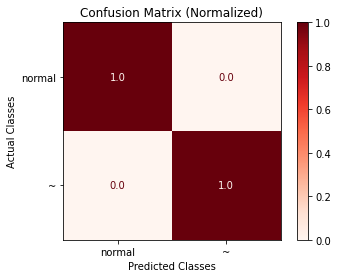

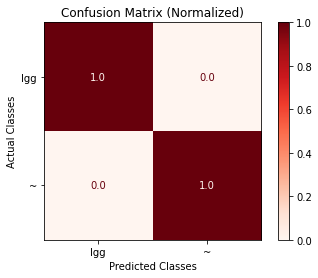

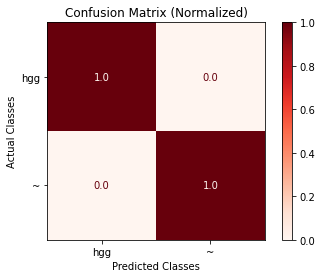

In [58]:
cm.plot(cmap=plt.cm.Reds,number_label=True,normalized=True,one_vs_all=True,class_name="normal")
cm.plot(cmap=plt.cm.Reds,number_label=True,normalized=True,one_vs_all=True,class_name="lgg")
cm.plot(cmap=plt.cm.Reds,number_label=True,normalized=True,one_vs_all=True,class_name="hgg")

In [59]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

In [60]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names))


Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        20
         lgg       1.00      1.00      1.00        20
         hgg       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

